In [29]:
!pip install --upgrade scikit-learn==1.4.2 imbalanced-learn==0.12.2 --quiet

# Step 1: Import required libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import kagglehub


# Step 2: Load and preview the data


In [41]:
path = kagglehub.dataset_download("shivamb/machine-predictive-maintenance-classification")
df = pd.read_csv(path + "/predictive_maintenance.csv")

df.head()



,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [43]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


# Step 3: Clean column names


In [44]:
def clean(df):
    df = df.copy()
    df.columns = df.columns.str.replace(r"[\[\]<>\(\)]", "", regex=True)
    return df

df = clean(df)
df.columns


Index(['UDI', 'Product ID', 'Type', 'Air temperature K',
       'Process temperature K', 'Rotational speed rpm', 'Torque Nm',
       'Tool wear min', 'Target', 'Failure Type'],
      dtype='object')

# Step 4: Visualize class distribution


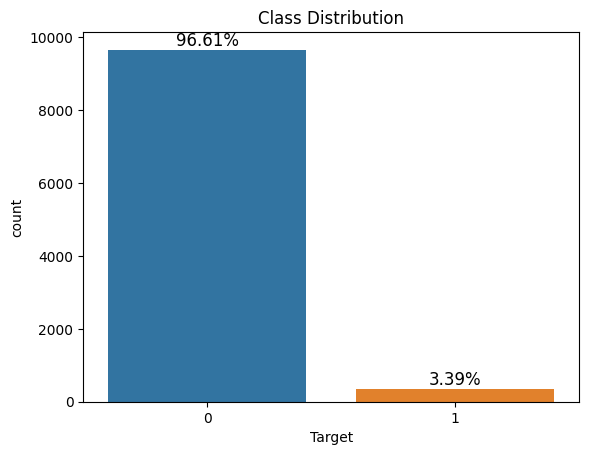

In [45]:
class_counts = df['Target'].value_counts()
class_percentages = df['Target'].value_counts(normalize=True) * 100

sns.countplot(x='Target', data=df)
plt.title('Class Distribution')

for i, count in enumerate(class_counts):
    percent = class_percentages.iloc[i]
    plt.text(i, count + 5, f"{percent:.2f}%", ha='center', va='bottom', fontsize=12)

plt.show()


**insights and how it benefits your analysis**, especially in a machine learning context:

---

### Class Distribution Analysis

#### What This Graph Shows:

This bar chart displays the distribution of the target variable in the dataset. The two classes are:

- `0`: The **majority class**, comprising **96.61%** of the data.
- `1`: The **minority class**, making up only **3.39%** of the data.

Each bar is annotated with the **percentage** of its class relative to the total dataset, making the class imbalance immediately visible and understandable.

---

### 🔍 Key Insights:

- **Severe Class Imbalance**: The vast difference between the two classes suggests a highly imbalanced dataset.
- **Minority Class (1) is underrepresented**: This can lead to biased machine learning models that perform well on class `0` but poorly on class `1`.

---

### 💡 Why This Is Important:

- **Model Bias Risk**: A naive classifier might achieve high accuracy by always predicting class `0`, ignoring class `1`.
- **Metric Selection**: You should not rely on accuracy alone; consider using **precision**, **recall**, **F1-score**, or **ROC-AUC** instead.
- **Data Preprocessing**:

  - Use **resampling techniques**

---


# Step 5: Correlation heatmap (excluding ID columns)


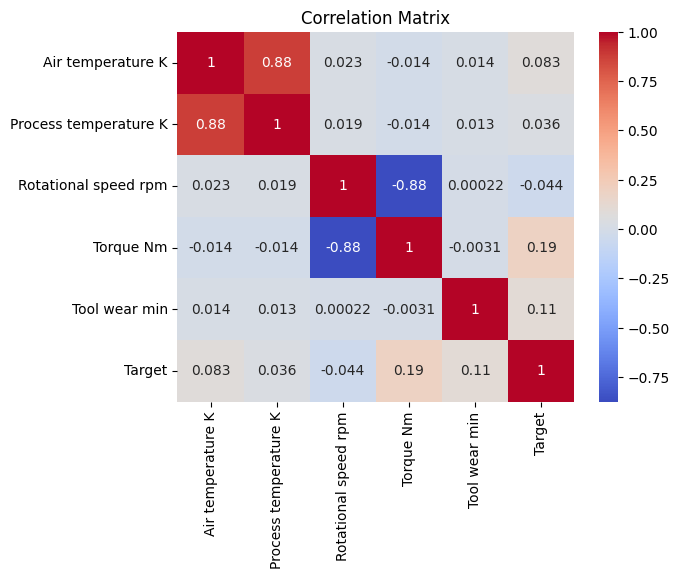

In [46]:
corr = df.drop(columns=['UDI', 'Product ID']).corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


---
###  Correlation Matrix Heatmap
---

### What This Graph Shows:

This **correlation matrix** visualizes the pairwise **linear relationships** between numerical features in the dataset. Values range from:

- **+1 (Red)** → perfect positive correlation
- **0 (White)** → no correlation
- **–1 (Blue)** → perfect negative correlation

The matrix highlights both **feature-feature** and **feature-target** correlations.

---

### Key Insights:

1. **High Positive Correlation**:

   - `Air temperature K` and `Process temperature K` show a strong positive correlation (**0.88**), suggesting potential redundancy.

2. **Strong Negative Correlation**:

   - `Rotational speed rpm` and `Torque Nm` are strongly negatively correlated (**–0.88**). This could indicate inverse dependency — as rotational speed increases, torque decreases.

3. **Target Relationships**:

   - `Torque Nm` shows the highest correlation with the target (**0.19**), followed by `Tool wear min` (**0.11**) and `Air temperature K` (\*\*0.083\`). Though these are weak correlations, they may still be valuable in combination with other features in a predictive model.

4. **Low Multicollinearity Among Others**:

   - Other features show very low correlation, which can be beneficial in model training since they bring unique information.

---

### Why This Matters:

- **Feature Selection**:

- Helps identify redundant features (e.g., `Air temp` & `Process temp`) which could be candidates for removal or PCA.
- **Avoid Multicollinearity**:

  - Strongly correlated features can hurt some models (like linear regression), leading to instability in coefficients.

- **Target Understanding**:

- Guides feature engineering by highlighting which variables are most related to the prediction target.

---


# Step 6: Plot feature distributions and boxplots


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


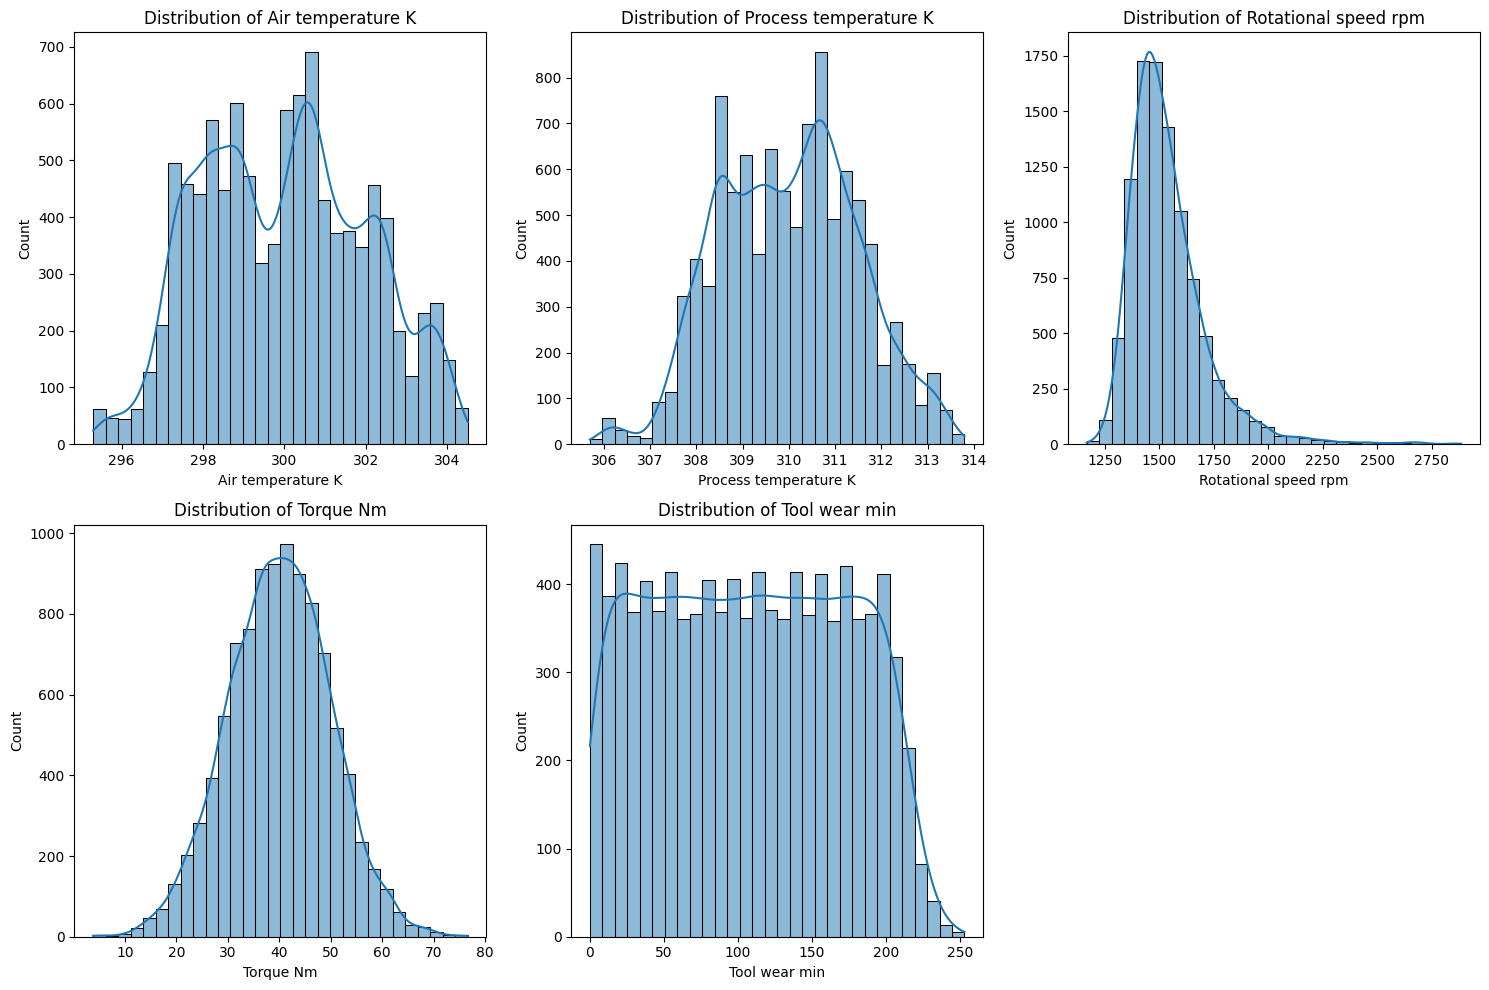

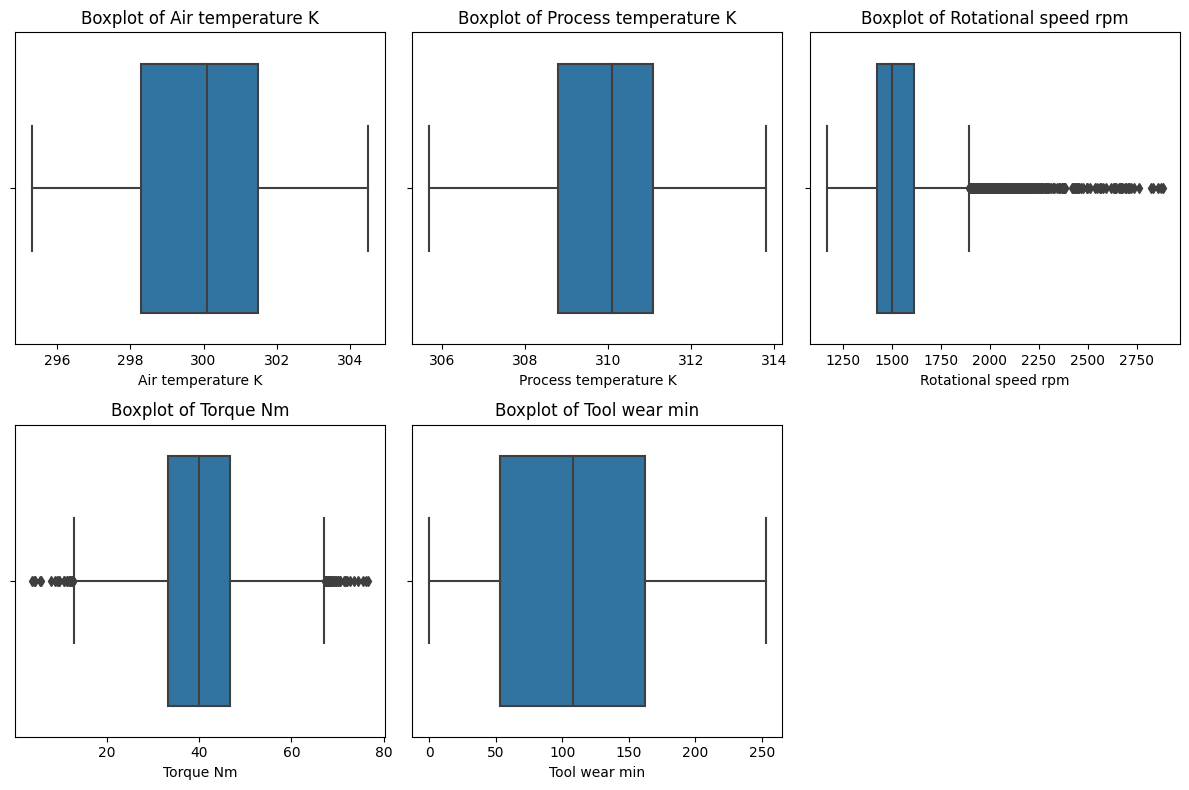

In [47]:
def plot_distributions(df, features):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(features, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    for i, col in enumerate(features, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.tight_layout()
    plt.show()

features = ['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
plot_distributions(df, features)


---
###  Feature Distribution Plots

###  What These Graphs Show:

These histograms (with KDE curves) represent the **distribution of numerical features** in the dataset. Understanding these distributions helps in choosing the right preprocessing steps and models.
---

### Feature-by-Feature Insights:

1. #### Air Temperature (K)

   - **Shape**: Slightly right-skewed, multimodal.
   - **Insight**: Multiple operating conditions or shifts in process environment could cause this.
   - **Add-on**: May require normalization or binning depending on the model.

2. #### Process Temperature (K)

   - **Shape**: Similar to air temperature but more centered.
   - **Insight**: Stable process behavior with minor fluctuations.
   - **Add-on**: Could pair well with air temperature due to their high correlation.

3. #### Rotational Speed (rpm)

   - **Shape**: **Right-skewed**, long tail.
   - **Insight**: Most operations happen in a narrow range; some rare high-speed outliers.
   - **Add-on**: Consider **log transformation** to reduce skewness before modeling.

4. #### Torque (Nm)

   - **Shape**: **Nearly normal distribution**, symmetric bell curve.
   - **Insight**: Well-behaved variable—ideal for most machine learning models.
   - **Add-on**: High-quality predictor; strong correlations with other features and target.

5. #### Tool Wear (min)

   - **Shape**: **Uniform until a sharp drop**, indicating capped or maxed-out wear time.
   - **Insight**: Likely limited by machine rules or maximum usage threshold.
   - **Add-on**: Could signal when a tool needs replacement—important for predictive maintenance.

---

### Why This Analysis Matters:

- **Helps Choose Preprocessing**: Skewed features like `Rotational Speed` may need transformation.
- **Feature Engineering**: Distributions guide decisions about binning, normalization, and outlier handling.
- **Improves Model Performance**: Ensures models trained on data aligned with algorithm assumptions (e.g., normality for linear models).
- **Highlights Operational Constraints**: Flat distributions with sharp cutoffs (e.g., Tool Wear) indicate system-imposed thresholds.

---


# Step 7: Prepare leaky


In [48]:
# 5. Prepare datasets for different leakage scenarios

# Scenario 1: No Leak
df_no_leak = df.drop(columns=['UDI', 'Failure Type'])

# Scenario 2: 'Failure Type' Leak (FTL)
# 'Failure Type' is kept as a feature. 'UDI' is dropped.
df_failure_type_leak = df.drop(columns=['UDI'])

# Scenario 3: New 'Future Information' Leak (FIL)
# Create a synthetic feature that depends on the target
# This simulates leaking information from the future or the target itself into a feature
# Ensure 'Target' is numeric for this operation (it is, 0 or 1)
df_copy_for_fil = df.copy()
df_copy_for_fil['future_info_leak_feat'] = df_copy_for_fil['Torque Nm'] + df_copy_for_fil['Target'] * np.random.uniform(low=5.0, high=15.0, size=len(df_copy_for_fil)) 
df_future_info_leak = df_copy_for_fil.drop(columns=['UDI', 'Failure Type']) # Exclude original 'Failure Type' to isolate this new leak

In [ ]:
# %%
# 6. Define feature sets for each scenario
base_numerical_features = ['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']

# Common categorical feature for all scenarios (unless it's the leaker itself)
# 'Product ID' is used for GroupKFold, not as a direct model feature in ColumnTransformer

# Scenario 1: No Leak
num_feats_nl = base_numerical_features
cat_feats_nl = ['Type']

# Scenario 2: Failure Type Leak
num_feats_ftl = base_numerical_features
cat_feats_ftl = ['Type', 'Failure Type'] # 'Failure Type' is the leaking feature

# Scenario 3: Future Info Leak
num_feats_fil = base_numerical_features + ['future_info_leak_feat'] # 'future_info_leak_feat' is the leaking feature
cat_feats_fil = ['Type']


# Step 8: pipeline setup


In [ ]:
def split_X_y_groups(df_to_split, target_col='Target', group_col='Product ID'):
    X = df_to_split.drop(columns=[target_col])
    y = df_to_split[target_col]
    # Ensure Product ID is not in X if it's only for grouping
    if group_col in X.columns:
        groups = X[group_col]
        X = X.drop(columns=[group_col]) # Remove group_col from X if it's still there
    else: # If Product ID was already dropped (e.g. in df_no_leak it's still there before split)
        # We need to get it from the original df with the same index
        groups = df_original.loc[X.index, 'Product ID']

    return X, y, groups

X_nl, y_nl, g_nl = split_X_y_groups(df_no_leak)
X_ftl, y_ftl, g_ftl = split_X_y_groups(df_failure_type_leak)
X_fil, y_fil, g_fil = split_X_y_groups(df_future_info_leak)

# Define preprocessors for each scenario
def create_preprocessor(num_features, cat_features):
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
    ])
    # Check if cat_features is empty, as ColumnTransformer errors with empty list for a transformer
    transformers_list = [('num', numeric_transformer, num_features)]
    if cat_features: # Only add categorical transformer if there are categorical features
        transformers_list.append(('cat', categorical_transformer, cat_features))
    
    return ColumnTransformer(transformers_list, remainder='drop')

preprocessor_nl = create_preprocessor(num_feats_nl, cat_feats_nl)
preprocessor_ftl = create_preprocessor(num_feats_ftl, cat_feats_ftl)
preprocessor_fil = create_preprocessor(num_feats_fil, cat_feats_fil)

resampler = SMOTETomek(random_state=42)

# Step 9: Define hyperparameters and perform GridSearchCV


In [ ]:
def make_pipeline(clf, preprocessor_obj):
    return ImbPipeline([
        ('pre', preprocessor_obj),
        ('resample', resampler),
        ('clf', clf)
    ])

# Define pipelines and their corresponding data & preprocessors
pipelines_dict = {
    'LR_no_leak': {'pipeline_func': make_pipeline(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, solver='liblinear'), preprocessor_nl), 'data': (X_nl, y_nl, g_nl), 'preprocessor': preprocessor_nl, 'num_feats': num_feats_nl, 'cat_feats': cat_feats_nl},
    'XGB_no_leak': {'pipeline_func': make_pipeline(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), preprocessor_nl), 'data': (X_nl, y_nl, g_nl), 'preprocessor': preprocessor_nl, 'num_feats': num_feats_nl, 'cat_feats': cat_feats_nl},
    
    'LR_failure_type_leak': {'pipeline_func': make_pipeline(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, solver='liblinear'), preprocessor_ftl), 'data': (X_ftl, y_ftl, g_ftl), 'preprocessor': preprocessor_ftl, 'num_feats': num_feats_ftl, 'cat_feats': cat_feats_ftl},
    'XGB_failure_type_leak': {'pipeline_func': make_pipeline(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), preprocessor_ftl), 'data': (X_ftl, y_ftl, g_ftl), 'preprocessor': preprocessor_ftl, 'num_feats': num_feats_ftl, 'cat_feats': cat_feats_ftl},

    'LR_future_info_leak': {'pipeline_func': make_pipeline(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, solver='liblinear'), preprocessor_fil), 'data': (X_fil, y_fil, g_fil), 'preprocessor': preprocessor_fil, 'num_feats': num_feats_fil, 'cat_feats': cat_feats_fil},
    'XGB_future_info_leak': {'pipeline_func': make_pipeline(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), preprocessor_fil), 'data': (X_fil, y_fil, g_fil), 'preprocessor': preprocessor_fil, 'num_feats': num_feats_fil, 'cat_feats': cat_feats_fil},
}

# Define grid search parameters
grid_params_dict = {
    'LR_no_leak': {'clf__C': [0.01, 0.1, 1, 10]},
    'XGB_no_leak': {'clf__n_estimators': [50, 100], 'clf__max_depth': [3, 5], 'clf__scale_pos_weight': [(y_nl==0).sum()/(y_nl==1).sum() if (y_nl==1).sum() > 0 else 1]},
    
    'LR_failure_type_leak': {'clf__C': [0.01, 0.1, 1, 10]},
    'XGB_failure_type_leak': {'clf__n_estimators': [50, 100], 'clf__max_depth': [3, 5], 'clf__scale_pos_weight': [(y_ftl==0).sum()/(y_ftl==1).sum() if (y_ftl==1).sum() > 0 else 1]},

    'LR_future_info_leak': {'clf__C': [0.01, 0.1, 1, 10]},
    'XGB_future_info_leak': {'clf__n_estimators': [50, 100], 'clf__max_depth': [3, 5], 'clf__scale_pos_weight': [(y_fil==0).sum()/(y_fil==1).sum() if (y_fil==1).sum() > 0 else 1]},
}

gkf = GroupKFold(n_splits=3) 
best_models = {}
print("\nStarting model training and hyperparameter tuning...")
for name, info in pipelines_dict.items():
    pipe = info['pipeline_func']
    X_train_full, y_train_full, groups_train_full = info['data']
    current_grid_search_params = grid_params_dict[name]
    
    print(f"\nTuning {name}...")
    # Ensure X_train_full does not contain 'Product ID' if it was used for groups
    if 'Product ID' in X_train_full.columns:
         X_train_full_for_fit = X_train_full.drop(columns=['Product ID'])
    else:
         X_train_full_for_fit = X_train_full

    grid = GridSearchCV(pipe, current_grid_search_params, cv=gkf.split(X_train_full_for_fit, y_train_full, groups_train_full), scoring='f1', n_jobs=-1, verbose=1)
    grid.fit(X_train_full_for_fit, y_train_full)
    best_models[name] = grid.best_estimator_
    print(f"{name} best params: {grid.best_params_}, CV F1: {grid.best_score_:.3f}")



Starting model training and hyperparameter tuning...

Tuning LR_no_leak...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
LR_no_leak best params: {'clf__C': 1}, CV F1: 0.240

Tuning XGB_no_leak...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
XGB_no_leak best params: {'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__scale_pos_weight': 28.49852507374631}, CV F1: 0.540

Tuning LR_failure_type_leak...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
LR_failure_type_leak best params: {'clf__C': 10}, CV F1: 0.986

Tuning XGB_failure_type_leak...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
XGB_failure_type_leak best params: {'clf__max_depth': 5, 'clf__n_estimators': 50, 'clf__scale_pos_weight': 28.49852507374631}, CV F1: 0.973

Tuning LR_future_info_leak...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
LR_future_info_leak best params: {'clf__C': 10}, CV F1: 1.000

Tuning XGB_future_info_leak...
Fitting 3 folds for each 

# Step 10: Evaluation: ROC, SHAP, confusion matrices



Starting model evaluation...

=== Evaluation for LR_no_leak ===
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      1932
           1       0.15      0.82      0.25        68

    accuracy                           0.83      2000
   macro avg       0.57      0.83      0.58      2000
weighted avg       0.96      0.83      0.88      2000



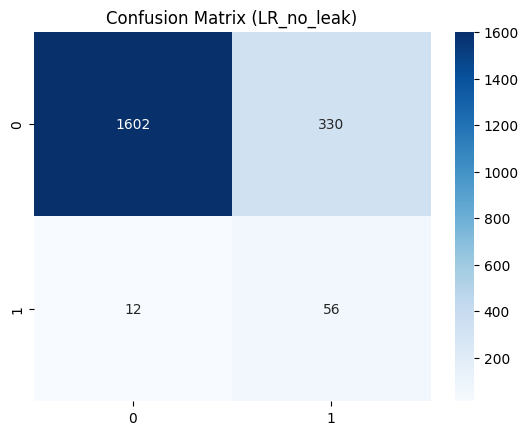

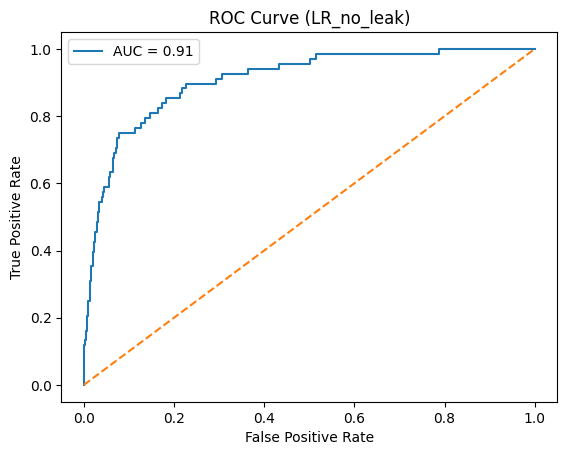

Number of features for SHAP for LR_no_leak: 7
Shape of transformed_X_te for LR_no_leak: (2000, 7)


  0%|          | 0/2000 [00:00<?, ?it/s]

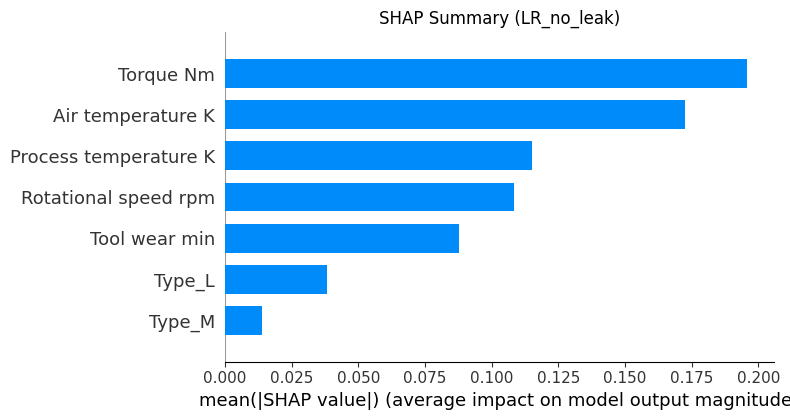


=== Evaluation for XGB_no_leak ===
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1932
           1       0.43      0.84      0.56        68

    accuracy                           0.96      2000
   macro avg       0.71      0.90      0.77      2000
weighted avg       0.97      0.96      0.96      2000



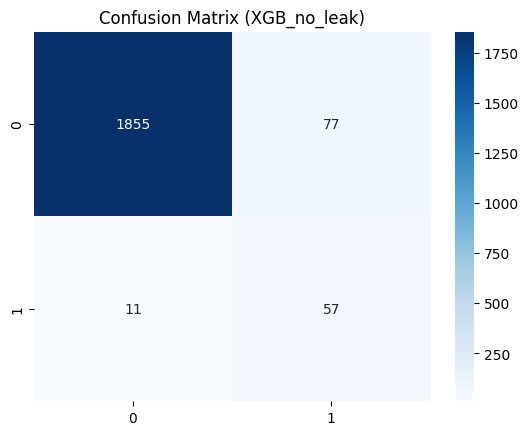

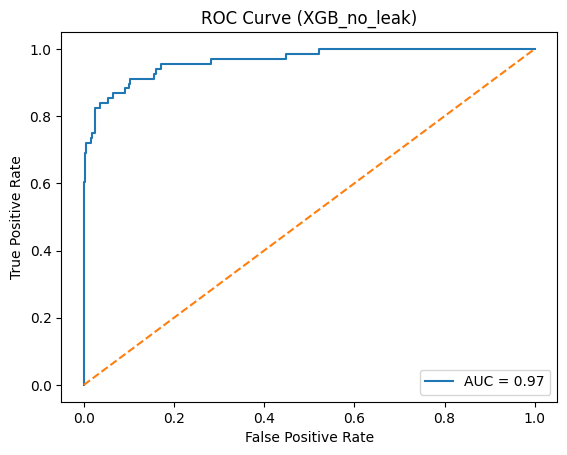

Number of features for SHAP for XGB_no_leak: 7
Shape of transformed_X_te for XGB_no_leak: (2000, 7)


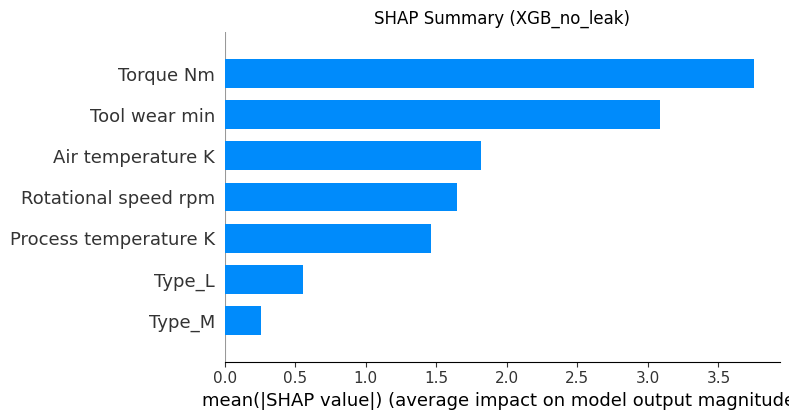


=== Evaluation for LR_failure_type_leak ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



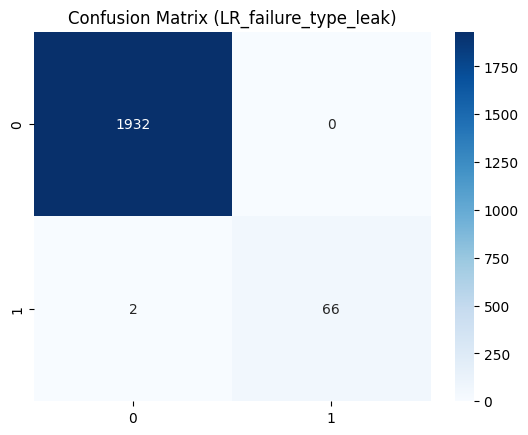

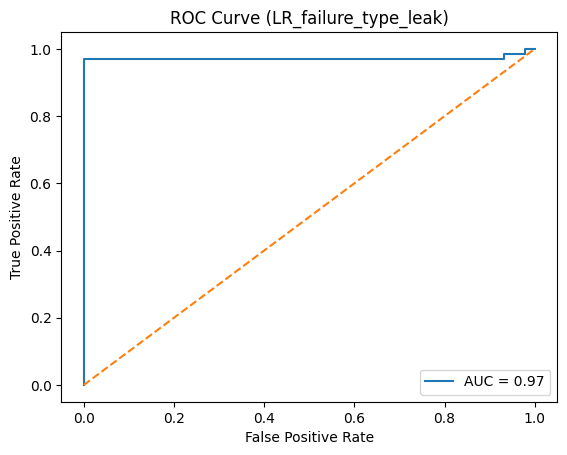

Number of features for SHAP for LR_failure_type_leak: 12
Shape of transformed_X_te for LR_failure_type_leak: (2000, 12)


  0%|          | 0/2000 [00:00<?, ?it/s]

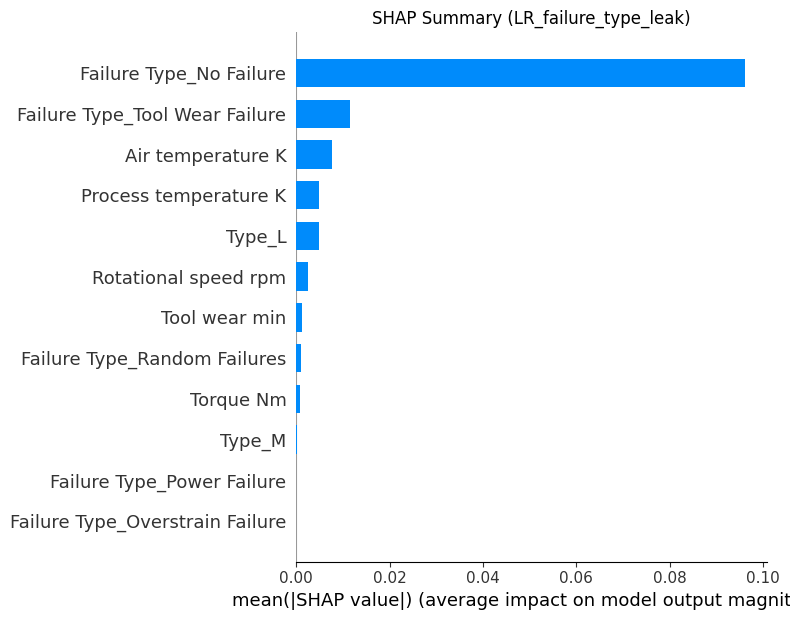


=== Evaluation for XGB_failure_type_leak ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       0.99      0.97      0.98        68

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



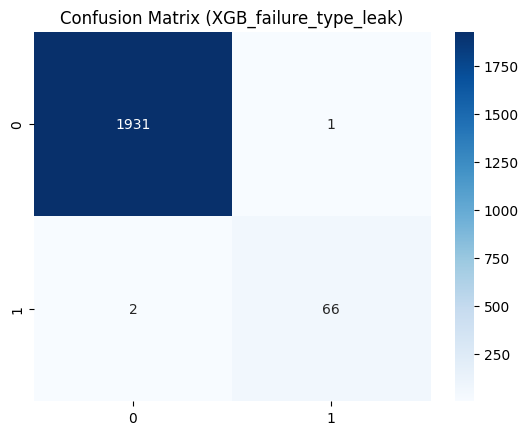

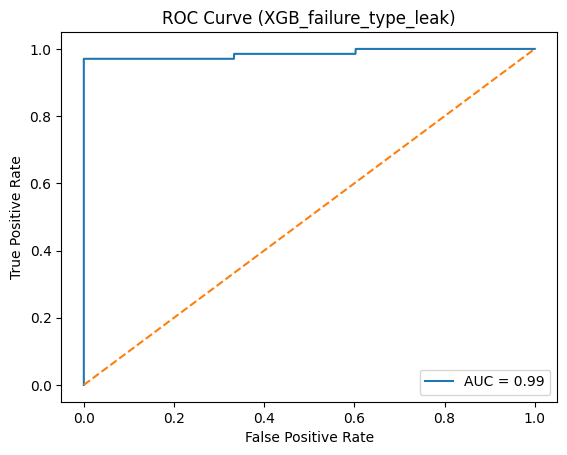

Number of features for SHAP for XGB_failure_type_leak: 12
Shape of transformed_X_te for XGB_failure_type_leak: (2000, 12)


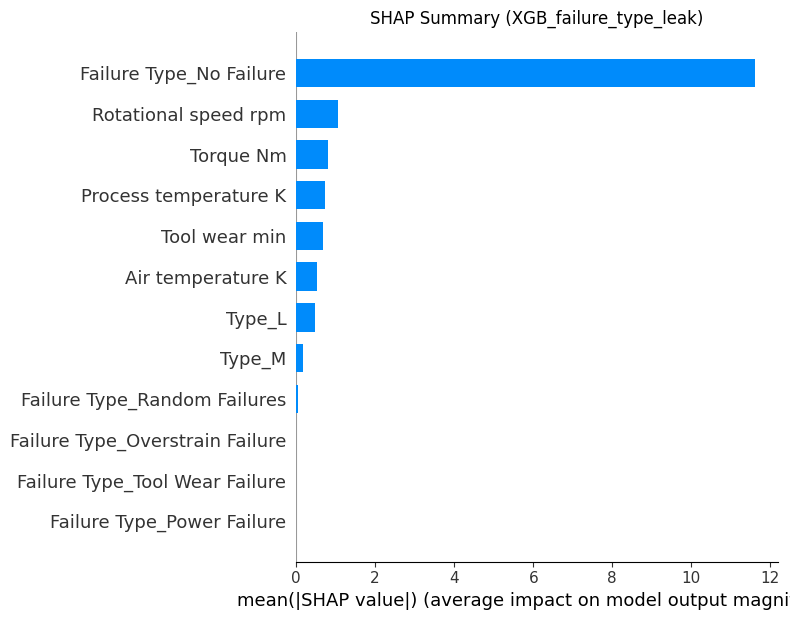


=== Evaluation for LR_future_info_leak ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      1.00      1.00        68

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



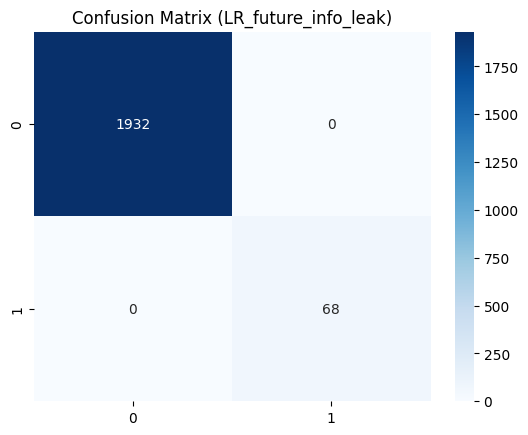

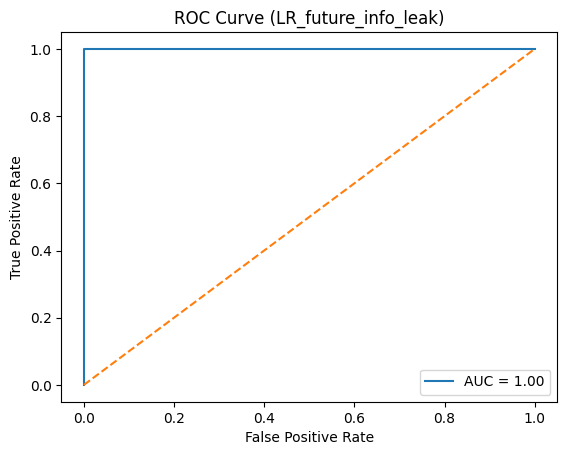

Number of features for SHAP for LR_future_info_leak: 8
Shape of transformed_X_te for LR_future_info_leak: (2000, 8)


  0%|          | 0/2000 [00:00<?, ?it/s]

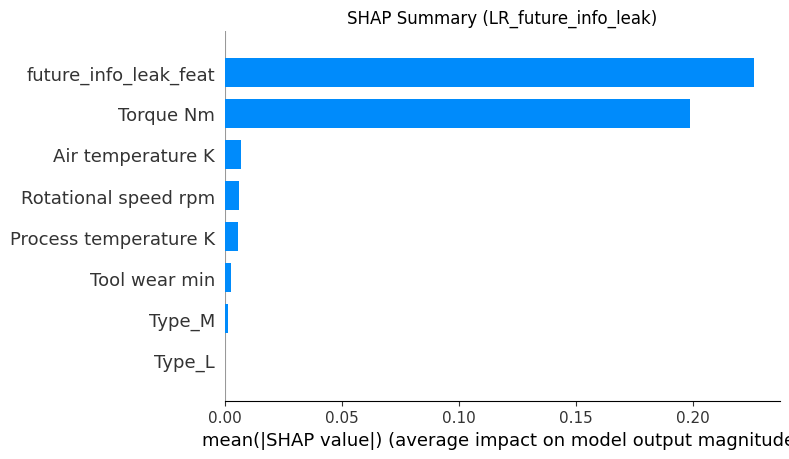


=== Evaluation for XGB_future_info_leak ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       0.99      0.99      0.99        68

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



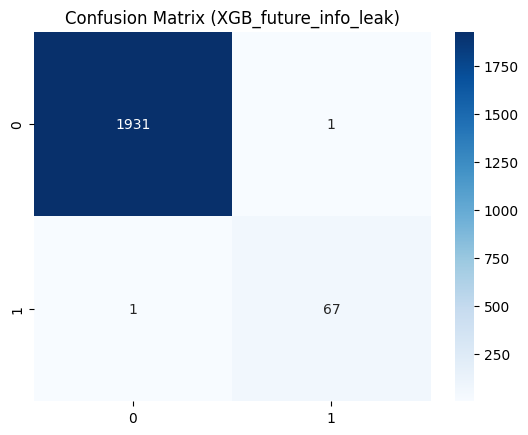

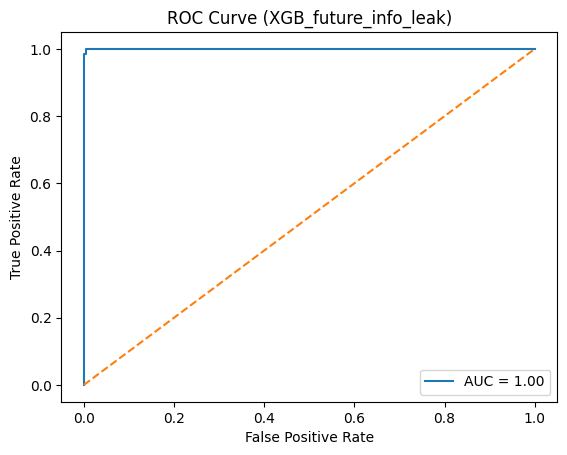

Number of features for SHAP for XGB_future_info_leak: 8
Shape of transformed_X_te for XGB_future_info_leak: (2000, 8)


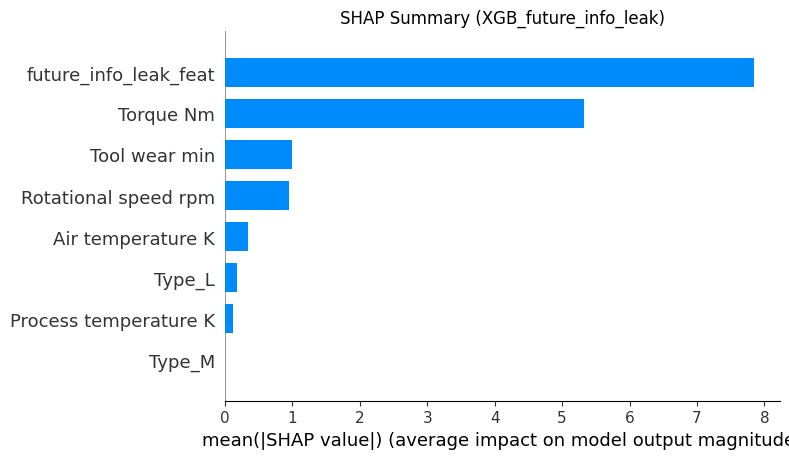


All evaluations complete. Plots displayed on screen.


In [ ]:
print("\nStarting model evaluation...")

for name, model in best_models.items():
    info = pipelines_dict[name]
    X_base, y_base, _ = info['data']  # Use the full X, y for the split corresponding to this model
    preprocessor_obj = info['preprocessor']
    current_num_features = info['num_feats']
    current_cat_features = info['cat_feats']

    # Ensure Product ID is not in X_base before splitting if it was handled separately for groups
    if 'Product ID' in X_base.columns:
        X_base_for_split = X_base.drop(columns=['Product ID'])
    else:
        X_base_for_split = X_base

    X_tr, X_te, y_tr, y_te = train_test_split(X_base_for_split, y_base, test_size=0.2, random_state=42, stratify=y_base)

    # Model is already tuned, fit on the training part of this split for consistent SHAP
    model.fit(X_tr, y_tr)
    y_proba = model.predict_proba(X_te)[:, 1]
    y_pred = model.predict(X_te)

    # Classification report & confusion matrix
    print(f"\n=== Evaluation for {name} ===")
    print(classification_report(y_te, y_pred, zero_division=0))
    plt.figure()
    sns.heatmap(confusion_matrix(y_te, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix ({name})")
    plt.show()

    # ROC curve
    auc = roc_auc_score(y_te, y_proba)
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve ({name})")
    plt.legend()
    plt.show()

    # SHAP summary
    transformed_X_te = model.named_steps['pre'].transform(X_te)
    transformed_X_tr = model.named_steps['pre'].transform(X_tr)  

    # Get feature names after preprocessing
    feature_names_out = []
    feature_names_out.extend(current_num_features)
    if current_cat_features:
        ohe_transformer = model.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
        ohe_feature_names = ohe_transformer.get_feature_names_out(current_cat_features)
        feature_names_out.extend(list(ohe_feature_names))

    print(f"Number of features for SHAP for {name}: {len(feature_names_out)}")
    print(f"Shape of transformed_X_te for {name}: {transformed_X_te.shape}")

    if transformed_X_te.shape[1] != len(feature_names_out):
        print(f"WARNING for {name}: Mismatch in transformed columns ({transformed_X_te.shape[1]}) and feature names ({len(feature_names_out)}). SHAP plot might be incorrect.")

    try:
        if 'XGB' in name:
            explainer = shap.TreeExplainer(model.named_steps['clf'])
            shap_values = explainer.shap_values(transformed_X_te)
        else:  # Logistic Regression
            background_sample = shap.sample(transformed_X_tr, 100)
            explainer = shap.KernelExplainer(model.named_steps['clf'].predict_proba, background_sample)
            shap_values = explainer.shap_values(transformed_X_te)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]

        plt.figure()
        if not isinstance(transformed_X_te, pd.DataFrame):
            transformed_X_te_df_for_shap = pd.DataFrame(transformed_X_te, columns=feature_names_out[:transformed_X_te.shape[1]])
        else:
            transformed_X_te_df_for_shap = transformed_X_te

        shap.summary_plot(
            shap_values,
            transformed_X_te_df_for_shap,
            feature_names=feature_names_out[:transformed_X_te.shape[1]],
            plot_type='bar',
            show=False
        )
        plt.title(f"SHAP Summary ({name})")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generating SHAP summary for {name}: {e}")

print("\nAll evaluations complete. Plots displayed on screen.")
